In [1]:
#IMPORT LIBRARIES

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from __future__ import print_function
from IPython.display import clear_output as clc

plt.style.use('default')

# Videos loading

In [2]:
# LOAD VIDEO DATA

from PIL import Image
from torchvision import transforms

nvideos = 2
filenames = ['Data/GoPro_video' + str(i) + '.gif' for i in range(1, nvideos + 1)]
videos = []

for filename in filenames:
    
    file = Image.open(filename)
    
    video = []
    try:
        while True:
            frame = file.convert('L')
        
            video.append(transforms.ToTensor()(frame))

            file.seek(file.tell() + 1)

    except EOFError:
        pass

    
    videos.append(torch.stack(video).squeeze(1))

videos = torch.stack(videos).squeeze(1)
nframes, Lx, Ly = videos[0].shape
nframe = Lx*Ly
nsnapshots = nvideos * nframes

In [1]:
# VIDEO EXAMPLE (PLOT)

from IPython.display import Image as play

whichvideo = 0
play(filenames[whichvideo])

In [4]:
# VIDEOS PREPROCESSING

threshold = 0.5

for i in range(nvideos):
    for j in range(nframes):
        videos[i,j][videos[i,j] > threshold] = threshold # Remove background
        videos[i,j] = (videos[i,j] - videos[i,j].min()) / (videos[i,j].max() - videos[i,j].min()) #MinMax scaler


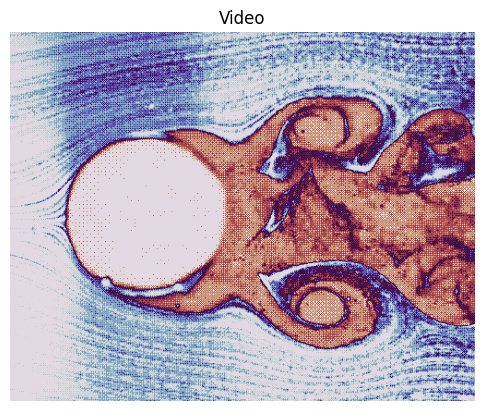

In [5]:
# VIDEO EXAMPLE (PLOT)

from utils.processdata import trajectory

whichvideo = 0
whichframes = torch.arange(0, 50)

def plot_frame(v, vmin = 0, vmax = 1):
    plt.imshow(v.reshape(Lx, Ly), cmap = "twilight_r", vmin = vmin, vmax = vmax)

trajectory(videos[whichvideo, whichframes], plot_frame, figsize = (6, 5), title = "Video", fontsize = 12)

In [6]:
# TRAIN-VALIDATION-TEST SPLITTING

np.random.seed(0)

ntrain = round(0.8 * nsnapshots)

idx_train = np.random.choice(nsnapshots, size = ntrain, replace = False)
mask = np.ones(nsnapshots)
mask[idx_train] = 0
idx_valid_test = np.arange(0, nsnapshots)[np.where(mask!=0)[0]]
idx_valid = idx_valid_test[::2]
idx_test = idx_valid_test[1::2]

nvalid = idx_valid.shape[0]
ntest = idx_test.shape[0]

# Videos compression - POD

In [7]:
# IMPORT FUNCTIONS FOR COMPUTING ERRORS

from utils.processdata import mre, num2p # Error metrics and format

In [8]:
# RESHAPE VIDEOS

videos = videos.reshape(nsnapshots, nframe)

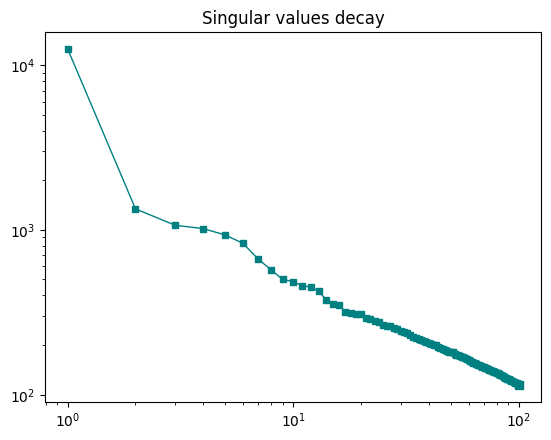

In [9]:
# PRINCIPAL ORTHOGONAL DECOMPOSITION

from sklearn.utils.extmath import randomized_svd

k = 100 # Number of POD modes

U, S, V = randomized_svd(videos[idx_train].numpy(), n_components = k)

teal = sns.light_palette("teal", 15)
plt.plot([i for i in range(1, k + 1)], S, color = teal[14], marker = 's', markersize = 5, linewidth = 1)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.loglog(k, S[k-1], color = teal[14], marker = 's', linestyle = '--')
plt.title("Singular values decay");

videos_POD = videos @ V.transpose()
videos_recontructed = torch.from_numpy((videos.numpy() @ V.transpose() @ V))

In [10]:
# POD RECONSTRUCTION ERROR ON TEST DATA

print("Mean relative POD reconstruction error: %s" % num2p(mre(videos[idx_test], videos_recontructed[idx_test])))

Mean relative POD reconstruction error: 11.96%


In [11]:
# SCALING

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler = scaler.fit(videos_POD[idx_train])
videos_POD = torch.from_numpy(scaler.transform(videos_POD))

In [12]:
# RESHAPE VIDEOS

videos = videos.reshape(nvideos, nframes, nframe)
videos_recontructed = videos_recontructed.reshape(nvideos, nframes, nframe)

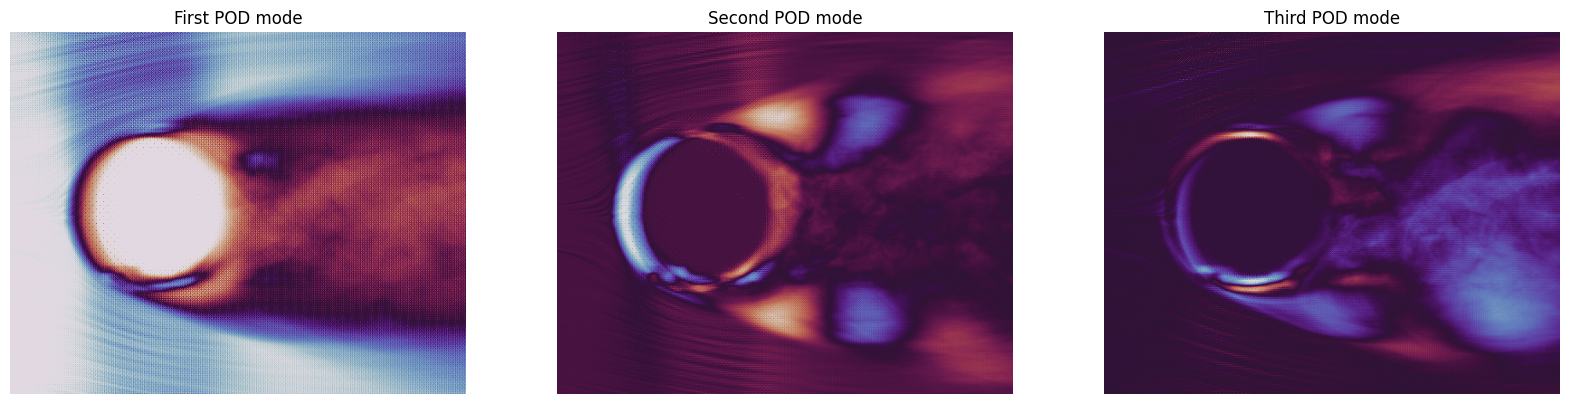

In [13]:
# POD MODES (PLOT)

plotlist = [V[0], V[1], V[2]]

from utils.processdata import multiplot

plot_frame_wrapper = lambda v: plot_frame(v, vmin = None, vmax = None)

multiplot(plotlist, plot_frame_wrapper, titles = ("First POD mode", "Second POD mode", "Third POD mode"), fontsize = 12, figsize = (20, 5))

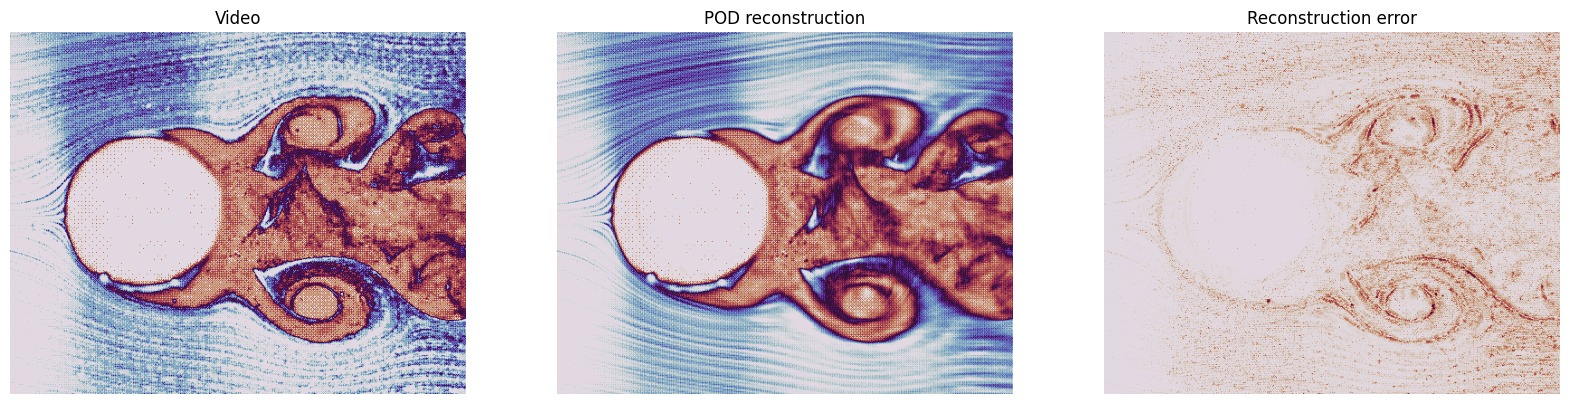

In [14]:
# VIDEO vs POD RECONSTRUCTION (PLOTS)

from utils.processdata import trajectories

whichvideo = 0
whichframes = torch.arange(0, 50)

plotlist = [videos[whichvideo, whichframes], videos_recontructed[whichvideo, whichframes], ((videos[whichvideo, whichframes] -  videos_recontructed[whichvideo, whichframes])**2).sqrt()]

trajectories(plotlist, plot_frame, titles = ("Video", "POD reconstruction", "Reconstruction error"), figsize = (20, 5), fontsize = 12)

# SHRED-ROM

In [22]:
# EXTRACT PIXELS DATA (SKIP THIS CELL IF DATA ALREADY AVAILABLE)

npixels = 3
pixels_coordinates = np.vstack((np.random.choice(Lx//2, size = npixels, replace = True) + Lx//4, np.random.choice(Ly//2, size = npixels, replace = True) + Ly//2)).T
pixels_data = torch.zeros(nvideos, nframes, npixels)

for i in range(nvideos):
    for j in range(nframes):
        pixels_data[i, j] = videos[i,j].reshape(Lx, Ly)[pixels_coordinates[:,0], pixels_coordinates[:,1]]

In [16]:
# LOAD PIXELS DATA

npixels = 3
pixels_coordinates = torch.load('Data/GoPro_pixels_coordinates.pt', weights_only = False)
pixels_data = torch.zeros(nvideos, nframes, npixels)

for i in range(nvideos):
    for j in range(nframes):
        pixels_data[i, j] = videos[i,j].reshape(Lx, Ly)[pixels_coordinates[:,0], pixels_coordinates[:,1]]

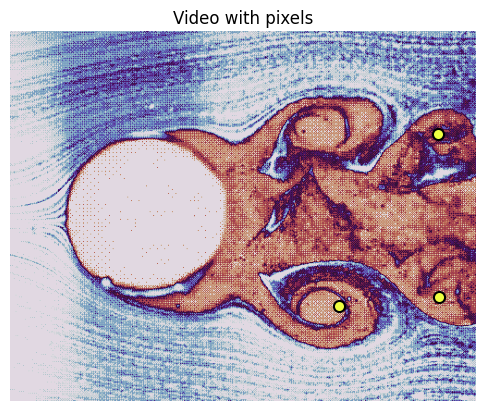

In [17]:
# VIDEO WITH PIXELS (PLOT) 

def video_with_pixels(vt, pixels_coordinates, title = None):
    """
    Video with pixels
    Input: video with dimension (ntimes, nframe) and pixels coordinates with dimension (2 * npixels)
    """
    plt.figure(figsize = (6, 5))
    for i in range(vt.shape[0]):
        plot_frame(vt[i])
        for k in np.arange(npixels):
            plt.plot(pixels_coordinates[k,1], pixels_coordinates[k,0], 'o', mfc = '#eeff41ff', mec = 'black', ms = 10, mew = 2)
        plt.title(title, fontsize = 12)
        plt.axis('off')
        display(plt.gcf())
        plt.close()
        clc(wait=True)

whichvideo = 0
whichframes = torch.arange(0, 50)

video_with_pixels(videos[whichvideo, whichframes], pixels_coordinates, title = "Video with pixels")

In [18]:
# BUILD INPUT AND OUTPUT DATASETS WITH PADDING

from utils.processdata import Padding, TimeSeriesDataset

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")

lag = 150

data_in = Padding(pixels_data, lag).to(device)
data_out = videos_POD.to(device)

train_dataset = TimeSeriesDataset(data_in[idx_train], data_out[idx_train])
valid_dataset = TimeSeriesDataset(data_in[idx_valid], data_out[idx_valid])
test_dataset = TimeSeriesDataset(data_in[idx_test], data_out[idx_test])

In [26]:
# SHRED TRAINING (SKIP THIS CELL IF SHRED ALREADY AVAILABLE)

from utils.models import SHRED, fit

shred = SHRED(npixels, k, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
train_errors, valid_errors = fit(shred, train_dataset, valid_dataset, batch_size = 64, epochs = 1000, lr = 1e-3, verbose = True, patience = 100)

In [20]:
# SHRED LOADING

from utils.models import SHRED

shred = SHRED(npixels, k, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
shred.load_state_dict(torch.load('NN/GoPro_shred.pt', weights_only = True, map_location=torch.device(device)));

In [21]:
# SHRED ERROR ON TEST DATA

from utils.processdata import mre, num2p # Error metrics and format

shred.freeze()

data_out_hat = shred(data_in).cpu()
videos_hat = torch.from_numpy(scaler.inverse_transform(data_out_hat)).float() @ V
videos_hat = videos_hat.reshape(nvideos, nframes, nframe)

print("Mean relative SHRED prediction error: %s" % num2p(mre(videos.reshape(nsnapshots, nframe)[idx_test], videos_hat.reshape(nsnapshots, nframe)[idx_test])))

Mean relative SHRED prediction error: 13.17%


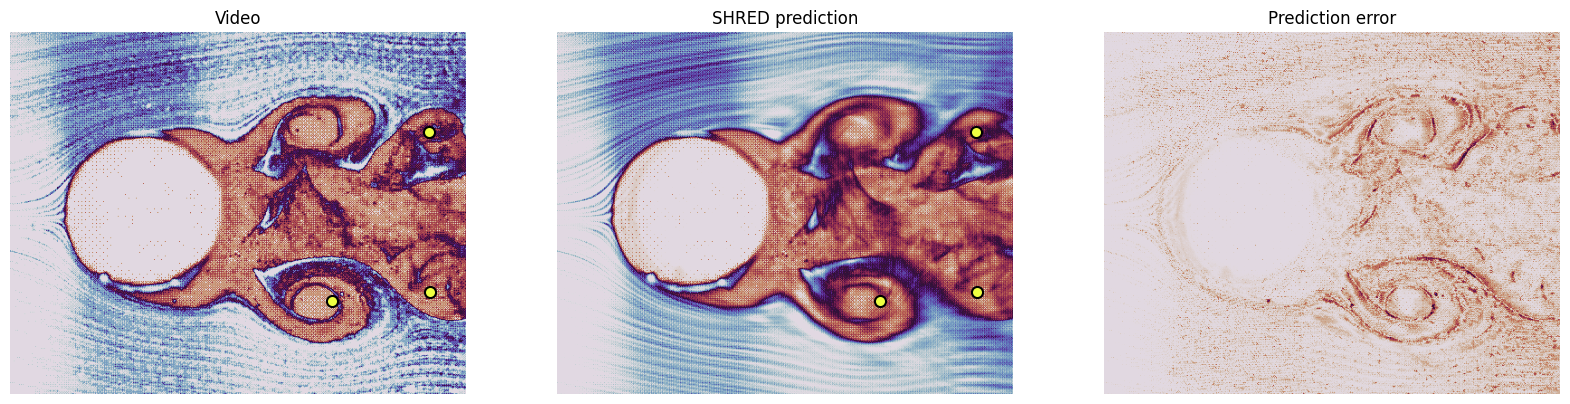

In [22]:
# VIDEO vs SHRED PREDICTION (PLOTS)

def videos_with_pixels(vts, pixels_coordinates, titles = None):
    """
    Videos with pixels
    Input: list of cideos with dimension (ntimes, nvelocity) and pixel coordinates
    """

    for i in range(vts[0].shape[0]):
    
        plt.figure(figsize = (20, 5))
        for j in range(len(vts)):
            plt.subplot(1, len(vts), j+1)
            plot_frame(vts[j][i])
            if j < len(vts)-1:
                for k in np.arange(npixels):
                    plt.plot(pixels_coordinates[k,1], pixels_coordinates[k,0], 'o', mfc = '#eeff41ff', mec = 'black', ms = 10, mew = 2)
        
            plt.title(titles[j], fontsize = 12)
            plt.axis('off')
        
        display(plt.gcf())
        plt.close()
        clc(wait=True)

whichvideo = 0
whichtimes = torch.arange(0, 50)

plotlist = [videos[whichvideo, whichtimes], videos_hat[whichvideo, whichtimes], ((videos[whichvideo, whichtimes] -  videos_hat[whichvideo, whichtimes])**2).sqrt()]

videos_with_pixels(plotlist, pixels_coordinates, titles = ("Video", "SHRED prediction", "Prediction error"))